In [ ]:
import time
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from datetime import datetime
from webdriver_manager.chrome import ChromeDriverManager

# Trustpilot review page URL
base_url = "https://www.trustpilot.com/review/www.allianztravelinsurance.com"

# Selenium WebDriver configuration
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Run in headless mode
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Launch the browser
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# List to store all reviews
all_reviews = []
max_pages = 5000 # Maximum pages to scrape

for page in range(1, max_pages + 1):
    print(f"📍 Scraping data from page {page}...")

    # Open the webpage
    driver.get(f"{base_url}?page={page}")
    time.sleep(3)  # Wait for the page to load

    # **Click all "See more" buttons before extracting content**
    while True:
        try:
            see_more_buttons = driver.find_elements(By.XPATH, "//button[contains(text(), 'See more')]")
            if not see_more_buttons:
                break  # Stop if no buttons are found

            for btn in see_more_buttons:
                driver.execute_script("arguments[0].click();", btn)
                time.sleep(1)  # Wait for the content to load

        except Exception as e:
            print(f"Error clicking 'See more': {e}")
            break

    # Get the HTML after expanding reviews
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Find all review blocks
    review_blocks = soup.find_all("article", class_=re.compile(r"styles_reviewCard__.*"))

    if not review_blocks:
        print("No more reviews found, stopping data extraction!")
        break

    # Iterate through each review:
    for idx, block in enumerate(review_blocks, 1):
        # 🔹 Extract reviewer name
        name_tag = block.find("span", class_=re.compile(r"typography_heading-xs__.* typography_appearance-default__.*"))
        reviewer_name = name_tag.get_text(strip=True) if name_tag else "N/A"

        # 🔹 Extract rating:
        rating_tag = block.find("img", alt=re.compile(r"Rated (\d) out of 5 stars"))
        if rating_tag:
            rating_value = re.search(r"Rated (\d) out of 5 stars", rating_tag["alt"]).group(1)
            rating = f"{rating_value} ⭐"
        else:
            rating = "N/A"

        # 🔹 Extract review date:
        date_tag = block.find("time")
        if date_tag:
            raw_date = date_tag["datetime"]  # Example: 2025-03-18T19:15:01.000Z
            review_date = datetime.strptime(raw_date[:10], "%Y-%m-%d").strftime("%b %d %Y")
        else:
            review_date = "N/A"

        # 🔹 Extract review content:
        review_text_tag = block.find("p", class_=re.compile(r"typography_body-l__.* typography_appearance-default__.*"))
        review_text = review_text_tag.get_text(strip=True) if review_text_tag else "N/A"

        # **Remove "See more" from the review content**
        review_text = re.sub(r"\bSee more\b", "", review_text, flags=re.IGNORECASE).strip()

        # 🔹 Add to the list
        all_reviews.append({
            "Review ID": len(all_reviews) + 1,
            "Reviewer Name": reviewer_name,
            "Rating": rating,  # Displays star rating as "5 ⭐"
            "Review Date": review_date,
            "Review Content": review_text
        })

# Close the browser
driver.quit()

# Convert data to a DataFrame
df = pd.DataFrame(all_reviews)

# Save as CSV
csv_filename = "trustpilot_reviews_cleaned.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8")

print(f"Successfully saved {len(df)} reviews to {csv_filename}")


📍 Scraping data from page 1...
📍 Scraping data from page 2...
📍 Scraping data from page 3...
📍 Scraping data from page 4...
📍 Scraping data from page 5...
📍 Scraping data from page 6...
📍 Scraping data from page 7...
📍 Scraping data from page 8...
📍 Scraping data from page 9...
📍 Scraping data from page 10...
📍 Scraping data from page 11...
📍 Scraping data from page 12...
📍 Scraping data from page 13...
📍 Scraping data from page 14...
📍 Scraping data from page 15...
📍 Scraping data from page 16...
📍 Scraping data from page 17...
📍 Scraping data from page 18...
📍 Scraping data from page 19...
📍 Scraping data from page 20...
📍 Scraping data from page 21...
📍 Scraping data from page 22...
📍 Scraping data from page 23...
📍 Scraping data from page 24...
📍 Scraping data from page 25...
📍 Scraping data from page 26...
📍 Scraping data from page 27...
📍 Scraping data from page 28...
📍 Scraping data from page 29...
📍 Scraping data from page 30...
📍 Scraping data from page 31...
📍 Scraping data f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [19]:
pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install pandas numpy scikit-learn nltk


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Tải stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Đọc dữ liệu từ Google Drive
file_path = "/content/drive/MyDrive/Final_Project/trustpilot_reviews_cleaned.csv"
df = pd.read_csv(file_path)

# Kiểm tra tên cột
print(df.columns)

# Xử lý missing values
df.dropna(subset=['Review Content'], inplace=True)

# Hàm làm sạch văn bản
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Xóa URL
    text = re.sub(r"[^a-z\s]", "", text)  # Chỉ giữ lại chữ cái
    text = " ".join([word for word in text.split() if word not in stop_words])  # Xóa stopwords
    return text

# Áp dụng làm sạch văn bản
df["cleaned_text"] = df["Review Content"].astype(str).apply(clean_text)

# Vector hóa dữ liệu bằng TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df["cleaned_text"])

# Chuyển thành DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Hiển thị dữ liệu sau khi xử lý
print(tfidf_df.head())

# Lưu dữ liệu đã xử lý
df.to_csv("/content/drive/MyDrive/Final_Project/processed_reviews.csv", index=False)
print("Dữ liệu đã xử lý và lưu thành công!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Index(['Review ID', 'Reviewer Name', 'Rating', 'Review Date',
       'Review Content'],
      dtype='object')
    aa  aaa   ab  abd  ability      able  aboard  aborted    abroad  \
0  0.0  0.0  0.0  0.0      0.0  0.000000     0.0      0.0  0.129727   
1  0.0  0.0  0.0  0.0      0.0  0.000000     0.0      0.0  0.000000   
2  0.0  0.0  0.0  0.0      0.0  0.000000     0.0      0.0  0.000000   
3  0.0  0.0  0.0  0.0      0.0  0.121034     0.0      0.0  0.000000   
4  0.0  0.0  0.0  0.0      0.0  0.000000     0.0      0.0  0.000000   

   abroadthe  ...  youthelma  youthis  youve  youwent  youwill   yr  yrs  yun  \
0        0.0  ...        0.0      0.0    0.0      0.0      0.0  0.0  0.0  0.0   
1        0.0  ...        0.0      0.0    0.0      0.0      0.0  0.0  0.0  0.0   
2        0.0  ...        0.0      0.0    0.0      0.0      0.0  0.0  0.0  0.0   
3        0.0  ...        0.0      0.0    0.0      0.0      0.0  0.0  0.0  0.0   
4        0.0  ...        0.0      0.0    0.0      0.0     

In [ ]:
print(df[["Review Content", "cleaned_text"]].head())


                                      Review Content  \
0  I incurred a "burn" on my leg from a motorcycl...   
1  The policy was very easy to buy. I was plannin...   
2  We have purchased travel insurance with Allian...   
3  My husband had unexpected open heart surgery t...   
4  Very good offer for travel insurance & the cos...   

                                        cleaned_text  
0  incurred burn leg motorcycle accident visiting...  
1  policy easy buy planning international trips o...  
2  purchased travel insurance allianz every trips...  
3  husband unexpected open heart surgery caused u...  
4      good offer travel insurance costs responsible  


In [ ]:
df.head()

,Review ID,Reviewer Name,Rating,Review Date,Review Content,cleaned_text
0,1,DS,5 ⭐,Mar 18 2025,"I incurred a ""burn"" on my leg from a motorcycl...",incurred burn leg motorcycle accident visiting...
1,2,NR,5 ⭐,Mar 18 2025,The policy was very easy to buy. I was plannin...,policy easy buy planning international trips o...
2,3,JY,5 ⭐,Mar 18 2025,We have purchased travel insurance with Allian...,purchased travel insurance allianz every trips...
3,4,DA,5 ⭐,Mar 18 2025,My husband had unexpected open heart surgery t...,husband unexpected open heart surgery caused u...
4,5,KA,5 ⭐,Mar 19 2025,Very good offer for travel insurance & the cos...,good offer travel insurance costs responsible


In [ ]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Khởi tạo VADER
analyzer = SentimentIntensityAnalyzer()

# Đọc dữ liệu đã xử lý
file_path = "/content/drive/MyDrive/Final_Project/processed_reviews.csv"
df = pd.read_csv(file_path)

# Hàm tính điểm cảm xúc
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score["compound"] >= 0.05:
        return "positive"
    elif score["compound"] <= -0.05:
        return "negative"
    else:
        return "neutral"

# Áp dụng phân tích cảm xúc
df["sentiment"] = df["cleaned_text"].astype(str).apply(get_sentiment)

# Kiểm tra kết quả
print(df[["Review Content", "cleaned_text", "sentiment"]].head())

# Lưu kết quả vào file mới
df.to_csv("/content/drive/MyDrive/Final_Project/vader_sentiment_reviews.csv", index=False)
print("Dữ liệu đã được phân tích cảm xúc và lưu thành công! 🎉")


                                      Review Content  \
0  I incurred a "burn" on my leg from a motorcycl...   
1  The policy was very easy to buy. I was plannin...   
2  We have purchased travel insurance with Allian...   
3  My husband had unexpected open heart surgery t...   
4  Very good offer for travel insurance & the cos...   

                                        cleaned_text sentiment  
0  incurred burn leg motorcycle accident visiting...  negative  
1  policy easy buy planning international trips o...  positive  
2  purchased travel insurance allianz every trips...  positive  
3  husband unexpected open heart surgery caused u...  positive  
4      good offer travel insurance costs responsible  positive  
Dữ liệu đã được phân tích cảm xúc và lưu thành công! 🎉


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Đọc dữ liệu đã phân tích bằng VADER
file_path = "/content/drive/MyDrive/Final_Project/vader_sentiment_reviews.csv"
df = pd.read_csv(file_path)

# Kiểm tra cột trong dữ liệu
print(df.columns)

# Chỉ lấy các cột cần thiết
df = df[['cleaned_text', 'sentiment']].dropna()

# Ánh xạ nhãn thành số (Machine Learning yêu cầu nhãn dạng số)
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["sentiment_label"] = df["sentiment"].map(label_mapping)

# Chia dữ liệu thành train/test
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["sentiment_label"], test_size=0.2, random_state=42)

# Vector hóa văn bản bằng TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Huấn luyện mô hình Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test_tfidf)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Machine Learning): {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))


Index(['Review ID', 'Reviewer Name', 'Rating', 'Review Date', 'Review Content',
       'cleaned_text', 'sentiment'],
      dtype='object')
Accuracy (Machine Learning): 0.76
              precision    recall  f1-score   support

    positive       0.89      0.43      0.58       376
    negative       0.74      0.99      0.85      1202
     neutral       1.00      0.01      0.03       213

    accuracy                           0.76      1791
   macro avg       0.88      0.48      0.49      1791
weighted avg       0.80      0.76      0.69      1791



<ipython-input-28-8e6c43b8484a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


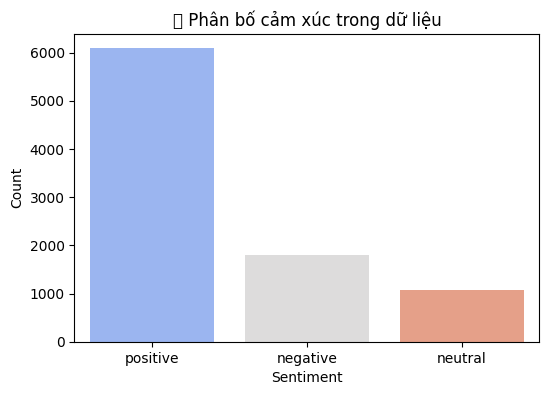

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu đã phân tích bằng VADER
file_path = "/content/drive/MyDrive/Final_Project/vader_sentiment_reviews.csv"  # Đảm bảo đường dẫn chính xác
df_sentiment = pd.read_csv(file_path)  # Đọc DataFrame vào biến df_sentiment

# Đếm số lượng từng loại cảm xúc
sentiment_counts = df_sentiment["sentiment"].value_counts()

# Vẽ biểu đồ cột
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")

# Thêm nhãn và tiêu đề
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("📊 Phân bố cảm xúc trong dữ liệu")
plt.show()

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Đọc dữ liệu đã phân tích bằng VADER
file_path = "/content/drive/MyDrive/Final_Project/vader_sentiment_reviews.csv"
df = pd.read_csv(file_path)

# Chỉ lấy các cột cần thiết
df = df[['cleaned_text', 'sentiment']].dropna()

# Ánh xạ nhãn thành số
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["sentiment_label"] = df["sentiment"].map(label_mapping)

# Chia dữ liệu thành train/test
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["sentiment_label"], test_size=0.2, random_state=42)

# Vector hóa văn bản bằng TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 🔥 Huấn luyện mô hình Logistic Regression
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test_tfidf)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy (Logistic Regression): {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))


🎯 Accuracy (Logistic Regression): 0.85
              precision    recall  f1-score   support

    positive       0.85      0.70      0.77       376
    negative       0.85      0.96      0.91      1202
     neutral       0.78      0.46      0.58       213

    accuracy                           0.85      1791
   macro avg       0.83      0.71      0.75      1791
weighted avg       0.85      0.85      0.84      1791



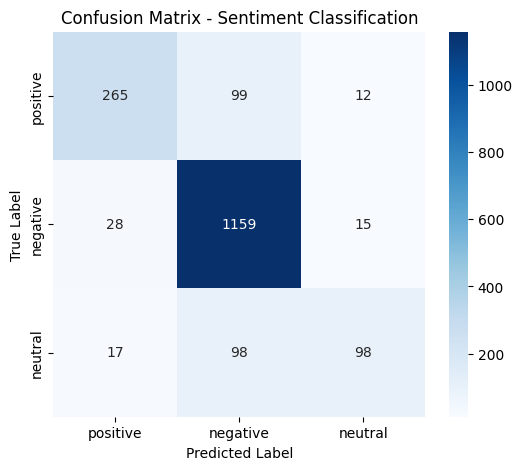

<ipython-input-31-b809e081500c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_mapping.keys()), y=[sum(y_pred == v) for v in label_mapping.values()], palette="Set2")


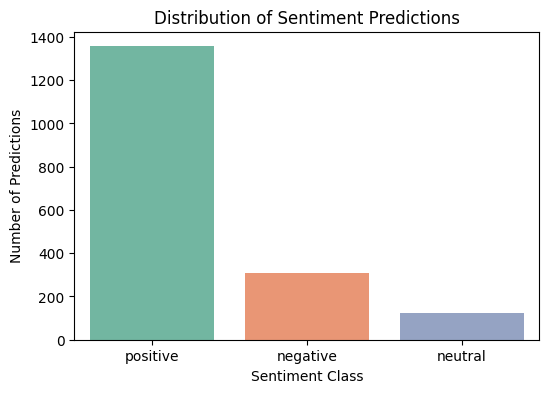

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 📌 Tạo Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 🎨 Vẽ Heatmap cho Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()

# 📊 Vẽ biểu đồ so sánh tỉ lệ dự đoán
plt.figure(figsize=(6, 4))
sns.barplot(x=list(label_mapping.keys()), y=[sum(y_pred == v) for v in label_mapping.values()], palette="Set2")
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Predictions")
plt.title("Distribution of Sentiment Predictions")
plt.show()


In [32]:
from xgboost import XGBClassifier

# 🔥 Huấn luyện mô hình XGBoost
model_xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
model_xgb.fit(X_train_tfidf, y_train)

# Dự đoán trên tập test
y_pred_xgb = model_xgb.predict(X_test_tfidf)

# Đánh giá mô hình
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"🎯 Accuracy (XGBoost): {accuracy_xgb:.2f}")
print(classification_report(y_test, y_pred_xgb, target_names=label_mapping.keys()))


🎯 Accuracy (XGBoost): 0.86
              precision    recall  f1-score   support

    positive       0.86      0.72      0.78       376
    negative       0.90      0.93      0.92      1202
     neutral       0.65      0.72      0.68       213

    accuracy                           0.86      1791
   macro avg       0.81      0.79      0.79      1791
weighted avg       0.86      0.86      0.86      1791



In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# 📌 Đọc dữ liệu
file_path = "/content/drive/MyDrive/Final_Project/vader_sentiment_reviews.csv"
df = pd.read_csv(file_path)

# 🔹 Chỉ lấy cột cần thiết
df = df[['cleaned_text', 'sentiment']].dropna()

# 🔹 Chuyển đổi sentiment thành số (1: positive, 0: negative, 2: neutral)
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["sentiment_label"] = df["sentiment"].map(label_mapping)

# 🔹 Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["sentiment_label"], test_size=0.2, random_state=42)

# 📌 Tokenizer (Chuyển văn bản thành số)
max_words = 5000  # Số lượng từ tối đa trong từ điển
max_len = 100  # Độ dài tối đa của mỗi câu

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 🔹 Padding để đảm bảo độ dài bằng nhau
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

# 📌 Xây dựng mô hình LSTM
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation="softmax")  # 3 lớp đầu ra tương ứng với sentiment
])

# 🔥 Compile mô hình
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 🚀 Huấn luyện mô hình
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

# 📌 Dự đoán trên tập test
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# 📊 Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy (LSTM): {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - accuracy: 0.6655 - loss: 0.8621 - val_accuracy: 0.6711 - val_loss: 0.8482
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 79s 235ms/step - accuracy: 0.6860 - loss: 0.8344 - val_accuracy: 0.6711 - val_loss: 0.8536
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.6856 - loss: 0.8359 - val_accuracy: 0.6711 - val_loss: 0.8481
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.6849 - loss: 0.8325 - val_accuracy: 0.6717 - val_loss: 0.8502
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - accuracy: 0.6806 - loss: 0.8411 - val_accuracy: 0.6717 - val_loss: 0.8475
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 80s 230ms/step - accuracy: 0.6905 - loss: 0.8278 - val_accuracy: 0.6717 - val_loss: 0.8477
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 230ms/step - accuracy: 0.6732 - loss: 0.8487 - val_accuracy: 0.6717 - val_loss: 0.8483
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 231ms/step - accuracy: 0.6868 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
